<a href="https://colab.research.google.com/github/lannaelvira77/WeatherWise-LannaElvira-23486942/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise: Intelligent Weather Analysis & Advisory System

***WeatherWise*** is an interactive Python application that provides real-time weather insights and intelligent activity recommendations using the OpenWeatherMap API.
<BR> The system integrates natural language processing (NLP) and visual analytics to let users ask weather-related questions conversationally (e.g., “*Will it rain tomorrow in Perth?*”) and receive both textual and graphical responses.

**Key features** include:
- 🌤 Live Weather Dashboard – view current and multi-day forecasts.
- 💬 Chatbot Mode – ask natural questions; receive smart, context-aware answers.
- 📊 Visual Analytics – temperature, rainfall, and humidity charts via Matplotlib.
- 🥾 Activity Advisor – simple AI heuristic to rate outdoor suitability (e.g., hiking).
- ⚙️ Robust API Handling – gracefully manages network errors, timeouts, and incomplete data.

🧭 Instructions for Running:
1. Click Runtime ▸ Run All (or press Ctrl+F9) to execute all cells.
2. Once all sections are loaded, scroll to Section 8 – Main Application Logic > Launch.
3. Run the final cell to start the interactive menu.
4. Choose between Dashboard or Chat to explore the system.


## 🧰 Setup and Imports

This section installs and imports the essential libraries used throughout the *Weather Advisor* project.
- matplotlib → for creating temperature, precipitation visualisations, etc
- pyinputplus → for building a console-style user interface with validated menu inputs.


In [55]:
!pip install matplotlib pyinputplus


In [56]:
# The plt.ion() command makes Matplotlib operate in interactive (non-blocking) mode so charts display immediately without freezing program execution.
import matplotlib.pyplot as plt
plt.ion()

## 📦 Setup and Configuration

This section configures environment variables and verifies the connection to the **OpenWeatherMap (OWM)** API.
<br> The API key is stored as an environment variable for secure access and reusability across modules.
A preliminary test request is performed to verify that the connection and credentials function correctly before further development.

### Store and Retrieve API Key

In [57]:
import os
# Set the API key as an environment variable
os.environ['OWM_API_KEY'] = "3940901d1d76b912b0cd840fd2b06ff7"

# Retrieve and store the key for later use
api_key = os.environ['OWM_API_KEY']

### Test API Connection

In [58]:
import requests

# Define test location
location = "Perth,AU"

# Build the API request URL (metric units for temperature in °C)
url = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}&units=metric"

# Send the GET request to the API endpoint
response = requests.get(url)

# Convert the API response to JSON format
data = response.json()

# Display the returned JSON data to confirm successful retrieval
print("✅ API connection test completed. Response preview:")
print(data)

✅ API connection test completed. Response preview:
{'coord': {'lon': 115.8333, 'lat': -31.9333}, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'base': 'stations', 'main': {'temp': 16.43, 'feels_like': 15.72, 'temp_min': 16.13, 'temp_max': 17.07, 'pressure': 1021, 'humidity': 61, 'sea_level': 1021, 'grnd_level': 1018}, 'visibility': 10000, 'wind': {'speed': 6.69, 'deg': 180}, 'clouds': {'all': 100}, 'dt': 1759647930, 'sys': {'type': 2, 'id': 2089443, 'country': 'AU', 'sunrise': 1759614565, 'sunset': 1759659640}, 'timezone': 28800, 'id': 2063523, 'name': 'Perth', 'cod': 200}


## 🌤️ Weather Data Functions

This section defines all functions responsible for retrieving, processing, and preparing weather data from the **OpenWeatherMap (OWM)** API.
<BR> It includes network request handling, caching, data aggregation, and error management to ensure consistent and efficient access to current and forecast information. The resulting data structures are used by the user interface, natural-language module, and visualisation components of the application.

Core tasks performed in this section:
- Establish API requests for current and 5-day forecasts.
- Implement lightweight caching to reduce repeated calls.
- Handle API errors and invalid inputs gracefully.
- Aggregate 3-hour forecast data into daily summaries.
- Provide helper functions (_safe_get, _make_error, etc.) for cleaner and safer data access.

### Imports, constants, and small utility functions

In [59]:
# This cell imports required modules and defines constants,
# helper functions, and basic error-handling utilities.

import os, requests, time, json
from datetime import datetime, timezone, timedelta
from collections import defaultdict

# Global cache and configuration
_WEATHER_CACHE = {}
_CACHE_TTL_SECONDS = 600        # Cache lifetime (10 minutes)
_RETRY_STATUS = {502, 503, 504} # Retry on transient server errors
_DEFAULT_TIMEOUT = 20           # Default HTTP timeout (seconds)

# Helper functions
def _now_utc():
    """Return the current UTC datetime."""
    return datetime.now(timezone.utc)

def _make_error(message, code=None, hint=None):
    """Standardized error format for consistent UI messages."""
    return {"error": {"message": message, "code": code, "hint": hint}}

def _safe_get(d, path, default=None):
    """Safely navigate nested dicts (avoids KeyErrors)."""
    cur = d
    for p in path:
        if not isinstance(cur, dict) or p not in cur:
            return default
        cur = cur[p]
    return cur

### Forecast aggregation helper

In [60]:
# This helper processes raw OWM 3-hourly forecast entries
# and computes average/min/max temperature and rainfall probability.

def _aggregate_daily_from_3h(forecast_json, forecast_days, tz_offset=0):
    three_hour_list = forecast_json.get("list", [])
    buckets = defaultdict(list)

    # Group entries by local date
    for item in three_hour_list:
        dt_txt = item.get("dt_txt")
        if not dt_txt:
            continue
        try:
            dt_obj = datetime.strptime(dt_txt, "%Y-%m-%d %H:%M:%S")
            local_dt = dt_obj + timedelta(seconds=tz_offset)
            day = local_dt.strftime("%Y-%m-%d")
        except Exception:
            day = dt_txt.split(" ")[0]
        buckets[day].append(item)

    daily_rows = []
    for day in sorted(buckets.keys()):
        rows = buckets[day]
        temps = [_safe_get(x, ["main","temp"]) for x in rows if _safe_get(x, ["main","temp"]) is not None]
        pops  = [x.get("pop") for x in rows if isinstance(x.get("pop"), (int, float))]
        descs = [_safe_get(x, ["weather"], [{}])[0].get("description") for x in rows]
        icons = [_safe_get(x, ["weather"], [{}])[0].get("icon") for x in rows]

        if not temps:
            continue

        temp_min, temp_max = min(temps), max(temps)
        temp_avg = sum(temps) / len(temps)
        pop_avg = (sum(pops) / len(pops) * 100.0) if pops else 0.0

        # Helper to find most common value in a list
        def _most_common(lst):
            if not lst: return None
            counts = {}
            for v in lst: counts[v] = counts.get(v, 0) + 1
            return max(counts, key=counts.get)

        description = (_most_common([d for d in descs if d]) or "").capitalize()
        icon = _most_common([i for i in icons if i]) or ""

        daily_rows.append({
            "date": day,
            "temp_min": round(temp_min, 2),
            "temp_max": round(temp_max, 2),
            "temp_avg": round(temp_avg, 2),
            "pop": round(pop_avg, 1),
            "description": description,
            "icon": icon
        })
    return daily_rows[:max(1, min(int(forecast_days), 5))]

### HTTP request with retry

In [61]:
# HTTP request helper with small retry mechanism
# Handles temporary network or provider errors gracefully.

def _http_get_with_retry(url, params, timeout=_DEFAULT_TIMEOUT, retries=1):
    for attempt in range(retries + 1):
        try:
            return requests.get(url, params=params, timeout=timeout)
        except requests.exceptions.RequestException:
            if attempt >= retries:
                raise
            time.sleep(0.8)  # short delay before retry


### Main weather data function

In [62]:
# Main function: get_weather_data()
# Retrieves current and forecast weather data from OWM API.
# Performs validation, caching, error handling, and formatting.

def get_weather_data(location, forecast_days=5, include_hourly_24h=True, use_cache=True):
    # Validate input
    if not isinstance(location, str) or not location.strip():
        return _make_error("Please provide a city name (e.g., 'Perth,AU').", code="bad_input")
    location = location.strip()
    try:
        forecast_days = int(forecast_days)
    except Exception:
        return _make_error("forecast_days must be an integer between 1 and 5.", code="bad_input")
    if not (1 <= forecast_days <= 5):
        return _make_error("forecast_days must be between 1 and 5.", code="bad_input")

    api_key = os.environ.get("OWM_API_KEY")
    if not api_key:
        return _make_error("Missing API key. Set OWM_API_KEY.", code="missing_api_key")

    # Cache check
    cache_key = (location.lower(), forecast_days)
    if use_cache and cache_key in _WEATHER_CACHE:
        cached = _WEATHER_CACHE[cache_key]
        if (_now_utc() - cached["fetched_at"]).total_seconds() < _CACHE_TTL_SECONDS:
            return cached["data"]

    # API request setup
    base_url_current = "https://api.openweathermap.org/data/2.5/weather"
    base_url_forecast = "https://api.openweathermap.org/data/2.5/forecast"
    params = {"q": location, "appid": api_key, "units": "metric"}

    try:
        # Current weather
        cur_res = _http_get_with_retry(base_url_current, params)
        if cur_res.status_code == 404:
            return _make_error(f"City not found: '{location}'.", code=404)
        cur_res.raise_for_status()

        # Forecast
        fct_res = _http_get_with_retry(base_url_forecast, params)
        fct_res.raise_for_status()
    except requests.exceptions.Timeout:
        return _make_error("The weather service timed out.", code="timeout")
    except requests.exceptions.RequestException as e:
        return _make_error(f"Network error: {e}", code="network")

    # Parse JSON
    cur_json = cur_res.json()
    fct_json = fct_res.json()
    if str(cur_json.get("cod")) != "200":
        return _make_error(cur_json.get("message", "Unknown provider error."), code=cur_json.get("cod"))

    # Extract and organize data
    fetched_at = _now_utc().isoformat()
    tz_seconds = _safe_get(cur_json, ["timezone"], 0)
    weather0 = _safe_get(cur_json, ["weather"], [{}])[0] or {}

    current = {
        "temp": round(_safe_get(cur_json, ["main","temp"], 0.0), 2),
        "description": weather0.get("description", "").capitalize(),
        "humidity": _safe_get(cur_json, ["main","humidity"], 0),
        "wind_speed": _safe_get(cur_json, ["wind","speed"], 0.0),
        "icon": weather0.get("icon", ""),
    }
    current["summary"] = f"{current['temp']}°C, {current['description']} (Humidity {current['humidity']}%, Wind {current['wind_speed']} m/s)"

    daily = _aggregate_daily_from_3h(fct_json, forecast_days, tz_offset=tz_seconds)

    # Optional 24-hour hourly data
    hourly_24h = None
    if include_hourly_24h:
        slots = (fct_json.get("list") or [])[:8]  # next 24h (3h intervals)
        hourly_24h = []
        for it in slots:
            w0 = _safe_get(it, ["weather"], [{}])[0] or {}
            hourly_24h.append({
                "dt": it.get("dt_txt"),
                "temp": round(_safe_get(it, ["main","temp"], 0.0), 2),
                "pop": round((it.get("pop") or 0) * 100.0, 1),
                "description": (w0.get("description") or "").capitalize(),
                "icon": w0.get("icon", "")
            })

    # Final structure
    data = {
        "meta": {"provider": "OpenWeatherMap", "fetched_at_utc": fetched_at, "units": "metric"},
        "location": {"query": location, "name": cur_json.get("name", location),
                     "country": _safe_get(cur_json, ["sys","country"], ""),
                     "lat": _safe_get(cur_json, ["coord","lat"]),
                     "lon": _safe_get(cur_json, ["coord","lon"]),
                     "timezone_offset_seconds": tz_seconds},
        "current": current,
        "daily": daily,
    }
    if hourly_24h is not None:
        data["hourly_24h"] = hourly_24h

    # Save to cache
    if use_cache:
        _WEATHER_CACHE[cache_key] = {"data": data, "fetched_at": _now_utc()}

    return data

### Cache helpers and quick test

In [63]:
# Cache utilities and quick verification
# Functions to check or clear cache, and test API output.

def weather_cache_info():
    """Return number of cached entries and cache duration."""
    return {"entries": len(_WEATHER_CACHE), "ttl_seconds": _CACHE_TTL_SECONDS}

def weather_cache_clear():
    """Clear all cached data."""
    _WEATHER_CACHE.clear()

# Test The Functions
import json

# Happy path
ok = get_weather_data("Perth,AU", 3)
print(json.dumps(ok, indent=2)[:600], "...")

# Bad city
bad = get_weather_data("NoSuchCityZZ,AU", 3)
print(bad)

# Bad forecast_days
bad_days = get_weather_data("Perth,AU", 9)
print(bad_days)

{
  "meta": {
    "provider": "OpenWeatherMap",
    "fetched_at_utc": "2025-10-05T07:05:30.999168+00:00",
    "units": "metric"
  },
  "location": {
    "query": "Perth,AU",
    "name": "Perth",
    "country": "AU",
    "lat": -31.9333,
    "lon": 115.8333,
    "timezone_offset_seconds": 28800
  },
  "current": {
    "temp": 16.43,
    "description": "Overcast clouds",
    "humidity": 61,
    "wind_speed": 6.69,
    "icon": "04d",
    "summary": "16.43\u00b0C, Overcast clouds (Humidity 61%, Wind 6.69 m/s)"
  },
  "daily": [
    {
      "date": "2025-10-05",
      "temp_min": 12.28,
      "temp ...
{'error': {'message': "City not found: 'NoSuchCityZZ,AU'.", 'code': 404, 'hint': None}}
{'error': {'message': 'forecast_days must be between 1 and 5.', 'code': 'bad_input', 'hint': None}}


## ⚙️ Shared Validators & Data Helpers

Defines small, reusable utilities that support input validation, date ranges, and simple activity scoring.
These helpers are independent of UI and API code, enabling reuse across modules and easier testing.

### Validators and date helpers

In [64]:
# Minimal, reusable helpers (validation and date utilities)
import re
from datetime import datetime, timedelta, timezone

def validate_location_format(loc: str) -> tuple[bool, str | None]:
    """Basic check for 'City' or 'City,CC'. Returns (is_valid, note_or_none)."""
    if not isinstance(loc, str) or not loc.strip():
        return False, "Please enter a non-empty city name (e.g., 'Perth,AU')."
    loc = loc.strip()
    if len(loc) < 2:
        return False, "City name seems too short."
    # Letters, spaces, hyphens, dots, apostrophes, optional ',CC'
    if not re.match(r"^[A-Za-z .'\-]+(,\s*[A-Za-z]{2})?$", loc):
        # Permissive: allow unusual formats but return a note
        return True, "Note: unusual city format; attempting lookup anyway."
    return True, None

def daterange(start_date: datetime, days: int):
    """Yield consecutive dates from start_date for N days."""
    for i in range(days):
        yield start_date + timedelta(days=i)

### Activity recommendation (hiking only)

In [65]:
# Simple activity scoring (hiking only) based on daily forecast dicts
def score_hiking_day(day: dict) -> tuple[int, list[str]]:
    """Return (score 0–100, reasons[]) for a given day."""
    reasons, score = [], 100
    t_avg = day.get("temp_avg")
    pop   = day.get("pop", 0.0)  # probability of precipitation in %

    # Temperature bands
    if t_avg is not None:
        if t_avg < 5:     score -= 35; reasons.append("very cold")
        elif t_avg < 12:  score -= 15; reasons.append("cool")
        elif t_avg > 35:  score -= 30; reasons.append("extreme heat")
        elif t_avg > 30:  score -= 15; reasons.append("hot")

    # Rain chance
    if pop >= 70:   score -= 40; reasons.append("high rain chance")
    elif pop >= 40: score -= 20; reasons.append("possible showers")

    score = max(0, min(100, score))
    return score, reasons

def recommend_activity(weather_data: dict, activity: str = "hiking", days: int | None = None) -> str:
    """Return a short recommendation summary for the next N days (hiking only)."""
    if not isinstance(weather_data, dict) or "error" in weather_data:
        return "Activity assessment unavailable due to missing weather data."

    daily = weather_data.get("daily") or []
    if not daily:
        return "No multi-day forecast available."

    k = max(1, min(days or len(daily), len(daily)))
    daily = daily[:k]

    if activity.lower() != "hiking":
        return f"No model for {activity} yet—try 'hiking'."

    lines, best = [], None
    for d in daily:
        score, reasons = score_hiking_day(d)
        tag = "✅ Good" if score >= 75 else ("⚠️ Fair" if score >= 50 else "❌ Poor")
        reason_txt = ", ".join(reasons) if reasons else "conditions look fine"
        lines.append(f"{d['date']}: {tag} ({score}/100) — {reason_txt}")
        best = max(best or (score, d['date']), (score, d['date']))

    summary = f"Recommendation for hiking in {weather_data['location']['name']} (next {k} days):\n" + \
              "\n".join("- " + x for x in lines)
    if best:
        summary += f"\n\nBest day: {best[1]} (score {best[0]}/100)."
    return summary

## 📊 Visualisation Functions

Provides reusable plotting utilities for the Weather Advisor.
<br> Charts are non-blocking (interactive) and accept an optional theme.
<br> Inputs are the structured dict returned by get_weather_data().

### Theme helpers and imports

In [66]:
# Visual style helpers used by all plots
import matplotlib.pyplot as plt
from datetime import datetime

DEFAULT_THEME = {
    "temp_line": "orange",
    "hourly_line": "orange",
    "rain_bar": "skyblue",
    "tmin_line": "blue",
    "tmax_line": "red",
    "bar_edge": "black",
    "grid_alpha": 0.6,
}

def apply_theme_color(theme: dict | None, key: str, fallback: str | None = None):
    """Return theme[key] if present, else fallback."""
    if isinstance(theme, dict) and key in theme:
        return theme[key]
    return fallback

### Temperature trend (daily average)

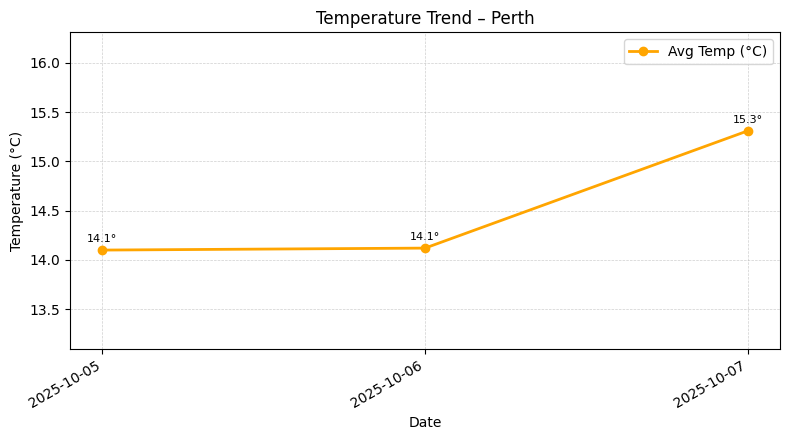

In [67]:
# Line chart of daily average temperature
def create_temperature_visualisation(weather_data, output_type='display', theme=None):
    """
    Plots daily average temperature from weather_data['daily'].
    Falls back to weather_data['forecast'] if needed.
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or "Selected Location"

    # Collect dates and temps
    daily = weather_data.get("daily") or []
    dates, temps = [], []
    if daily:
        for row in daily:
            d = row.get("date")
            t = row.get("temp_avg", row.get("temp"))
            if d is None or t is None:
                continue
            dates.append(d); temps.append(float(t))
    else:
        for row in weather_data.get("forecast", []):
            d, t = row.get("date"), row.get("temp")
            if d is None or t is None:
                continue
            dates.append(d); temps.append(float(t))

    if not dates or not temps:
        print("ℹ️ No temperature data available.")
        return None

    # Sort chronologically (best effort)
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), t) for d, t in zip(dates, temps)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _ in pairs]
        temps = [t for _, t in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    color = apply_theme_color(theme, "temp_line", "orange")
    ax.plot(dates, temps, marker='o', linewidth=2, color=color, label="Avg Temp (°C)")
    ax.set_title(f"Temperature Trend – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=apply_theme_color(theme, "grid_alpha", 0.6))
    ax.legend(loc="best")

    for x, y in zip(dates, temps):
        ax.annotate(f"{y:.1f}°", xy=(x, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    ymin, ymax = min(temps), max(temps)
    if ymin == ymax: ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.0, ymax + 1.0)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    try:
        plt.show(block=False); plt.pause(0.001)
    except Exception:
        pass
    return None

# Example
data = get_weather_data("Perth,AU", forecast_days=3)
create_temperature_visualisation(data)

### Precipitation probability

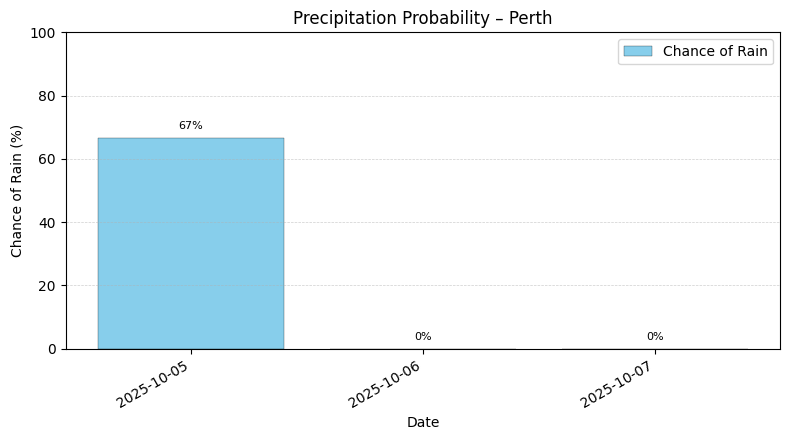

In [68]:
# Bar chart of daily probability of precipitation
def create_precipitation_visualisation(weather_data, output_type='display', theme=None):
    """Plots daily POP (%) from weather_data['daily']; falls back to descriptions if needed."""
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    def _theme(key, default):
        try:
            return apply_theme_color(theme, key, default)
        except Exception:
            return default

    title_location = weather_data.get("location", {}).get("name") or "Selected Location"

    dates, pops = [], []
    daily = weather_data.get("daily") or []
    if daily:
        for row in daily:
            d, p = row.get("date"), row.get("pop")
            if d is None or p is None:
                continue
            dates.append(d); pops.append(float(p))
    else:
        # Heuristic from text description
        for row in weather_data.get("forecast", []):
            d = row.get("date"); desc = (row.get("description") or "").lower()
            if not d: continue
            if any(w in desc for w in ("rain", "shower", "storm")): prob = 60.0
            elif "cloud" in desc: prob = 30.0
            else: prob = 10.0
            dates.append(d); pops.append(prob)

    if not dates:
        print("ℹ️ No precipitation data available for this period.")
        return None

    # Sort chronologically
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), p) for d, p in zip(dates, pops)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _ in pairs]
        pops  = [p for _, p in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.bar(dates, pops,
           label="Chance of Rain",
           color=_theme("rain_bar", "skyblue"),
           edgecolor=_theme("bar_edge", "black"),
           linewidth=0.2)
    ax.set_title(f"Precipitation Probability – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=_theme("grid_alpha", 0.6))
    ax.legend(loc="best")

    for i, v in enumerate(pops):
        ax.text(i, min(v + 2, 100), f"{v:.0f}%", ha='center', va='bottom', fontsize=8)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    try:
        plt.show(block=False); plt.pause(0.001)
    except Exception:
        pass
    return None

# Example
data = get_weather_data("Perth,AU", forecast_days=3)
create_precipitation_visualisation(data)

### Temperature range

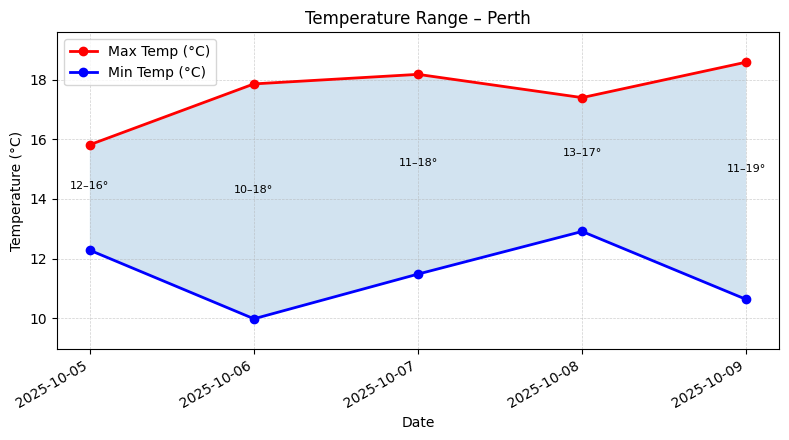

In [69]:
# Dual-line min/max with shaded band
def create_temperature_range_visualisation(weather_data, output_type='display', theme=None):
    """Plots daily min/max temperatures with a shaded range."""
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or "Selected Location"
    daily = weather_data.get("daily") or []
    dates, tmin, tmax = [], [], []
    for row in daily:
        d, lo, hi = row.get("date"), row.get("temp_min"), row.get("temp_max")
        if d is None or lo is None or hi is None:
            continue
        dates.append(d); tmin.append(float(lo)); tmax.append(float(hi))

    if not dates:
        print("ℹ️ No temperature range data available.")
        return None

    # Sort chronologically
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), lo, hi) for d, lo, hi in zip(dates, tmin, tmax)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _, _ in pairs]
        tmin  = [lo for _, lo, _ in pairs]
        tmax  = [hi for _, _, hi in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    c_max = apply_theme_color(theme, "tmax_line", "red")
    c_min = apply_theme_color(theme, "tmin_line", "blue")
    ax.plot(dates, tmax, marker='o', label="Max Temp (°C)", color=c_max, linewidth=2)
    ax.plot(dates, tmin, marker='o', label="Min Temp (°C)", color=c_min, linewidth=2)
    if len(dates) >= 2:
        ax.fill_between(dates, tmin, tmax, alpha=0.2)

    ax.set_title(f"Temperature Range – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=apply_theme_color(theme, "grid_alpha", 0.6))
    ax.legend(loc="best")

    for x, lo, hi in zip(dates, tmin, tmax):
        mid = (lo + hi) / 2
        ax.annotate(f"{lo:.0f}–{hi:.0f}°", xy=(x, mid), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    ymin, ymax = min(tmin + tmax), max(tmin + tmax)
    if ymin == ymax: ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.0, ymax + 1.0)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    try:
        plt.show(block=False); plt.pause(0.001)
    except Exception:
        pass
    return None

# Example
data = get_weather_data("Perth,AU", forecast_days=5)
create_temperature_range_visualisation(data)

### Current wind & humidity

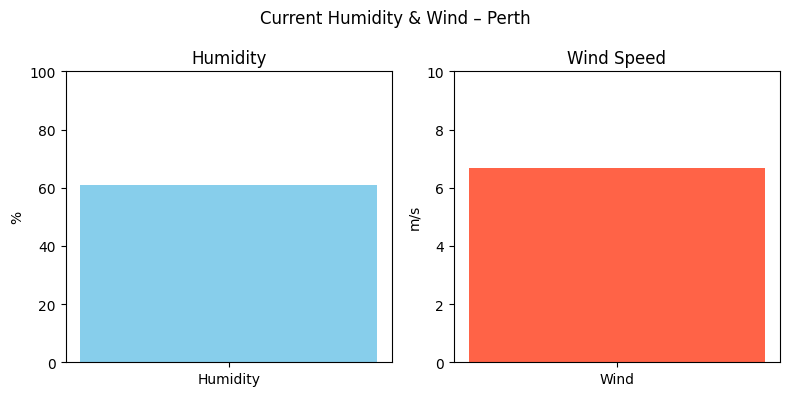

In [70]:
# Simple side-by-side bars for current humidity and wind speed
def create_wind_humidity_visualisation(weather_data, output_type='display', theme=None):
    """Plots current humidity (%) and wind speed (m/s) as two bars."""
    if not isinstance(weather_data, dict) or "current" not in weather_data:
        print("⚠️ Invalid data.")
        return None

    loc = weather_data["location"].get("name", "Selected Location")
    cur = weather_data["current"]
    humidity = cur.get("humidity", 0)
    wind = cur.get("wind_speed", 0)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].bar(["Humidity"], [humidity], color="skyblue")
    axs[0].set_ylim(0, 100); axs[0].set_ylabel("%"); axs[0].set_title("Humidity")

    axs[1].bar(["Wind"], [wind], color="tomato")
    axs[1].set_ylim(0, max(10, wind + 2)); axs[1].set_ylabel("m/s"); axs[1].set_title("Wind Speed")

    fig.suptitle(f"Current Humidity & Wind – {loc}")
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    try:
        plt.show(block=False); plt.pause(0.001)
    except Exception:
        pass
    return None

# Example (optional)
data = get_weather_data("Perth,AU", forecast_days=3)
create_wind_humidity_visualisation(data)

## 🤖 Natural Language Processing

Parses plain-English weather questions into structured intent and generates natural-language answers using fetched data.
<br> Includes date parsing, location extraction, intent classification, and optional activity-aware logic (hiking).

### Date parsing helpers

In [71]:
# Lightweight date parsing utilities (ISO and common formats)
import re
from datetime import datetime, timezone, timedelta

def _try_parse_date_to_iso(s: str) -> str | None:
    s = s.strip()
    # ISO and D/M/Y
    for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y"):
        try:
            return datetime.strptime(s, fmt).date().isoformat()
        except Exception:
            pass
    # D Month Y (8 October 2025)
    month_names = ("jan|january|feb|february|mar|march|apr|april|may|jun|june|jul|july|aug|august|"
                   "sep|september|oct|october|nov|november|dec|december")
    m = re.search(rf"\b(\d{{1,2}})\s+({month_names})\s+(\d{{4}})\b", s, flags=re.I)
    if m:
        d, mon, y = m.group(1), m.group(2).lower(), int(m.group(3))
        mm = {'jan':1,'january':1,'feb':2,'february':2,'mar':3,'march':3,'apr':4,'april':4,'may':5,
              'jun':6,'june':6,'jul':7,'july':7,'aug':8,'august':8,'sep':9,'september':9,
              'oct':10,'october':10,'nov':11,'november':11,'dec':12,'december':12}[mon]
        try: return datetime(y, mm, int(d)).date().isoformat()
        except Exception: return None
    # Month D, Y (Oct 8, 2025)
    m = re.search(rf"\b({month_names})\s+(\d{{1,2}})(?:st|nd|rd|th)?(?:,)?\s+(\d{{4}})\b", s, flags=re.I)
    if m:
        mon, d, y = m.group(1).lower(), int(m.group(2)), int(m.group(3))
        mm = {'jan':1,'january':1,'feb':2,'february':2,'mar':3,'march':3,'apr':4,'april':4,'may':5,
              'jun':6,'june':6,'jul':7,'july':7,'aug':8,'august':8,'sep':9,'september':9,
              'oct':10,'october':10,'nov':11,'november':11,'dec':12,'december':12}[mon]
        try: return datetime(y, mm, d).date().isoformat()
        except Exception: return None
    return None

def _extract_explicit_date(q_raw: str) -> str | None:
    """Find and normalize explicit dates from the raw question."""
    m = re.search(r"\b(20\d{2}-\d{1,2}-\d{1,2})\b", q_raw)
    if m:
        return _try_parse_date_to_iso(m.group(1))
    m = re.search(r"\b(\d{1,2}/\d{1,2}/20\d{2})\b", q_raw)
    if m:
        return _try_parse_date_to_iso(m.group(1))
    return _try_parse_date_to_iso(q_raw)

### Location extractor

In [72]:
# Extract a plausible location while ignoring dates/time phrases/activities
def _extract_location(s: str) -> str | None:
    if not isinstance(s, str) or not s.strip():
        return None
    text = s.strip()

    # Remove explicit dates to avoid false matches
    month_names = ("jan|january|feb|february|mar|march|apr|april|may|jun|june|jul|july|aug|august|"
                   "sep|september|oct|october|nov|november|dec|december")
    date_pattern = rf"""
        (?:\b20\d{{2}}-\d{{1,2}}-\d{{1,2}}\b) |
        (?:\b\d{{1,2}}/\d{{1,2}}/20\d{{2}}\b) |
        (?:\b\d{{1,2}}\s+(?:{month_names})\s+\d{{4}}\b) |
        (?:\b(?:{month_names})\s+\d{{1,2}}(?:st|nd|rd|th)?(?:,)?\s+\d{{4}}\b)
    """
    text = re.sub(date_pattern, " ", text, flags=re.I | re.VERBOSE)

    time_phrase = re.compile(r"""^(
        (?:the\s+)?next\s+\d+\s*(?:day|days)\b |
        next\s+few\s+days\b |
        today\b | tomorrow\b | tonight\b |
        this\s+(?:week|weekend|morning|afternoon|evening)\b
    )""", flags=re.I | re.X)

    STOP_LEAD = {
        "what","whats","what’s","will","is","are","do","does","should","can","could",
        "show","give","tell","temperature","temp","weather","forecast","rain","hourly",
        "please","display","chart","graph","next","this","today","tomorrow"
    }
    ACTIVITY_WORDS = {"hike","hiking","picnic","beach","swim","swimming","surf","surfing"}
    TRAILING_TIME = re.compile(r"""(\s*,?\s*)\b(
        today|tomorrow|tonight|this\s+(?:week|weekend|morning|afternoon|evening)
    )\b.*$""", flags=re.I | re.X)

    def clean_candidate(cand: str) -> str:
        cand = cand.strip()
        cand = re.sub(r"[?!\.;,:]+$", "", cand).strip()
        cand = TRAILING_TIME.sub("", cand).strip()
        return re.sub(r"\s+", " ", cand)

    def is_valid_place_token(tok: str) -> bool:
        t = tok.strip().lower()
        if t in STOP_LEAD or t in ACTIVITY_WORDS: return False
        if time_phrase.match(tok): return False
        return True

    candidates = []
    for prep in ("in", "at", "near", "around"):
        pat = re.compile(rf"\b{prep}\s+([A-Za-z][A-Za-z\.\-'\s]{{0,60}}(?:,\s*[A-Za-z]{{2,3}})?)", re.I)
        for m in pat.finditer(text):
            cand = clean_candidate(m.group(1))
            if not cand: continue
            head = cand.split()[0]
            if len(cand) >= 3 and is_valid_place_token(head) and not re.match(r"^(the\s+)?next\b", cand, flags=re.I):
                candidates.append((prep, cand))

    if candidates:
        last_in = [c for p, c in candidates if p == "in"]
        return last_in[-1] if last_in else candidates[-1][1]
    return None

### Base parser (intent extraction)

In [73]:
# Map a question to attribute/time/location/forecast_days/question_type
def parse_weather_question(question: str) -> dict:
    """
    Returns a structured intent dict used by the app (attribute, time_period, n, forecast_days, location, target_date, question_type, raw).
    """
    if not isinstance(question, str) or not question.strip():
        return {"error": "Empty question.", "raw": question}

    q_raw = question.strip()
    q = q_raw.lower()

    # Attribute
    if re.search(r"\b(temp|temperature|hot|cold|warm|cool)\b", q):
        attr = "temperature"
    elif re.search(r"\b(rain|raining|rainy|shower|showers|precip|precipitation|umbrella|wet)\b", q):
        attr = "rain"
    elif re.search(r"\b(wind|windy|gust|gusts)\b", q):
        attr = "wind"
    elif re.search(r"\b(humidity|humid)\b", q):
        attr = "humidity"
    elif re.search(r"\b(weather|forecast|clear|cloud|cloudy|sunny|storm|snow|overcast)\b", q):
        attr = "conditions"
    else:
        attr = "conditions"

    # Date → time period
    target_iso = _extract_explicit_date(q_raw)
    time_period, n_days = None, None
    if target_iso:
        time_period = "specific_date"
    else:
        if re.search(r"\btoday\b", q):
            time_period = "today"
        elif re.search(r"\btomorrow\b", q):
            time_period = "tomorrow"
        else:
            m = re.search(r"\bnext\s+(\d+)\s*(day|days)\b", q)
            if m:
                n_days = max(1, min(int(m.group(1)), 5))
                time_period = "next_n_days"
            elif re.search(r"\bnext\s+few\s+days\b", q):
                n_days = 3; time_period = "next_n_days"
            elif re.search(r"\bthis\s+week(end)?\b", q):
                n_days = 3; time_period = "next_n_days"
    if not time_period:
        time_period = "today"

    # Forecast horizon
    if time_period == "today":
        forecast_days = 1
    elif time_period == "tomorrow":
        forecast_days = 2
    elif time_period == "next_n_days":
        forecast_days = max(1, min(int(n_days or 3), 5))
    elif time_period == "specific_date":
        forecast_days = 5
    else:
        forecast_days = 3
    forecast_days = max(1, min(int(forecast_days), 5))

    # Question type
    if re.match(r"\s*(will|is|are|do|does|should|can|could)\b", q):
        question_type = "yesno"
    elif re.search(r"\bforecast|weather\b", q) and attr == "conditions":
        question_type = "summary"
    else:
        question_type = "value"

    # Location
    loc = _extract_location(q_raw)
    if loc:
        loc = re.sub(r"\s+", " ", loc)

    return {
        "attribute": attr,
        "time_period": time_period,
        "n": n_days,
        "forecast_days": forecast_days,
        "location": loc,
        "target_date": target_iso,
        "question_type": question_type,
        "raw": q_raw
    }

# Optional wrapper: detect activity (hiking) and request a wider horizon
def parse_weather_question_with_activities(question: str) -> dict:
    base = parse_weather_question(question)
    if not isinstance(base, dict) or "error" in base:
        return base

    q = (question or "").lower()
    activity = None
    if re.search(r"\b(hik(e|ing))\b", q) or re.search(r"\bgood\s+for\s+hiking\b", q):
        activity = "hiking"
    elif re.search(r"\b(picnic|beach|swim|swimming|surf(ing)?)\b", q):
        activity = "unsupported_activity"

    if activity:
        base["activity"] = activity
        base["forecast_days"] = max(3, min(5, int(base.get("forecast_days", 3))))
    return base

### Response generators

In [74]:
# Convert parsed intent + weather_data into a natural-language reply
def generate_weather_response(parsed_question: dict, weather_data: dict) -> str:
    if not isinstance(parsed_question, dict):
        return "Unable to understand the question format."
    if not isinstance(weather_data, dict):
        return "Weather information is unavailable at the moment."
    if "error" in weather_data:
        msg = weather_data["error"].get("message", "An unknown error occurred.")
        hint = weather_data["error"].get("hint")
        return f"Could not retrieve the weather. {msg}" + (f" Hint: {hint}" if hint else "")

    attr   = (parsed_question.get("attribute") or "conditions").lower()
    period = parsed_question.get("time_period") or "today"
    n_days = parsed_question.get("n")
    qtype  = parsed_question.get("question_type", "value")

    loc_name   = weather_data.get("location", {}).get("name") or weather_data.get("location") or "the selected location"
    tz_seconds = weather_data.get("location", {}).get("timezone_offset_seconds", 0)

    current = weather_data.get("current") or {}
    daily   = weather_data.get("daily")  or []

    def fmt_deg(v):
        try: return f"{float(v):.1f}°C"
        except: return "N/A"

    def fmt_pct(v):
        try: return f"{float(v):.0f}%"
        except: return "N/A"

    # Local "today" for index mapping
    local_now = datetime.now(timezone.utc) + timedelta(seconds=tz_seconds)
    local_today_str = local_now.date().strftime("%Y-%m-%d")

    idx_today, idx_tomorrow = None, None
    if daily:
        try: daily = sorted(daily, key=lambda d: d.get("date", "9999-12-31"))
        except Exception: pass
        for i, drow in enumerate(daily):
            ddate = drow.get("date")
            if not ddate: continue
            if ddate == local_today_str and idx_today is None: idx_today = i
            if ddate >  local_today_str and idx_tomorrow is None: idx_tomorrow = i
        if idx_today is None and daily and daily[0].get("date") == local_today_str: idx_today = 0
        if idx_tomorrow is None and idx_today is not None and (idx_today + 1) < len(daily): idx_tomorrow = idx_today + 1

    # Responses per period/attribute
    if period == "today":
        if attr == "temperature":
            if idx_today is not None:
                d = daily[idx_today]
                return (f"Today ({d.get('date')}) in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                        f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
            cur = current.get("temp")
            desc = (current.get("description") or "").lower()
            return f"Right now in {loc_name} it's {fmt_deg(cur)} and {desc or '—'}."
        elif attr == "rain":
            if idx_today is not None:
                d = daily[idx_today]; pop = d.get("pop", 0.0)
                base = f"The chance of rain today ({d.get('date')}) in {loc_name} is about {fmt_pct(pop)}."
                return ("Yes — " if pop >= 50 else "Probably not — ") + base if qtype == "yesno" else base
            desc = (current.get("description") or "").lower()
            likely = "likely" if any(k in desc for k in ["rain","shower"]) else "unlikely"
            return f"Rain is {likely} today in {loc_name} based on current conditions."
        elif attr == "wind":
            ws = current.get("wind_speed")
            return f"Current wind in {loc_name} is {ws:.1f} m/s." if ws is not None else f"Wind data isn't available for {loc_name} right now."
        elif attr == "humidity":
            h = current.get("humidity")
            return f"Humidity in {loc_name} is {h}%." if h is not None else f"Humidity data isn't available for {loc_name} right now."
        else:
            desc = current.get("description")
            return f"Currently in {loc_name}: {desc}, {fmt_deg(current.get('temp'))}." if desc else f"Current conditions unavailable for {loc_name}."

    elif period == "tomorrow":
        if idx_tomorrow is None:
            return f"No forecast available for tomorrow in {loc_name}."
        d = daily[idx_tomorrow]; date = d.get("date","tomorrow")
        if attr == "temperature":
            return (f"Tomorrow ({date}) in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                    f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
        elif attr == "rain":
            pop = d.get("pop", 0.0)
            return (("Yes" if pop >= 50 else "Probably not") + f". Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."
                    if qtype == "yesno" else f"Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}.")
        elif attr == "wind":
            return (f"Daily wind speeds for tomorrow are not available in this feed. "
                    f"Current wind is {current.get('wind_speed','N/A')} m/s.")
        elif attr == "humidity":
            return (f"Daily humidity for tomorrow is not provided in this feed. "
                    f"Current humidity is {current.get('humidity','N/A')}% in {loc_name}.")
        else:
            return f"Tomorrow ({date}) in {loc_name} looks {d.get('description','—').lower()} around {fmt_deg(d.get('temp_avg'))}."

    elif period == "specific_date":
        target_date = parsed_question.get("target_date")
        if not target_date:
            return f"The requested date could not be read for {loc_name}."
        match_idx = next((i for i, d in enumerate(daily) if d.get("date") == target_date), None)
        if match_idx is None:
            if daily:
                first, last = daily[0].get("date","?"), daily[-1].get("date","?")
                return f"Only a 5-day forecast is available: {first} to {last}. {target_date} is outside this range for {loc_name}."
            return f"No forecast includes {target_date} for {loc_name}."
        d, date = daily[match_idx], target_date
        if attr == "temperature":
            return (f"On {date} in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                    f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
        elif attr == "rain":
            pop = d.get("pop", 0.0)
            return (("Yes" if pop >= 50 else "Probably not") + f". Chance of rain on {date} in {loc_name} is {fmt_pct(pop)}."
                    if qtype == "yesno" else f"Chance of rain on {date} in {loc_name} is {fmt_pct(pop)}.")
        elif attr == "wind":
            return ("Daily wind speeds are not available for specific dates in this feed. "
                    f"Current wind: {current.get('wind_speed','N/A')} m/s.")
        elif attr == "humidity":
            return ("Daily humidity is not provided for specific dates in this feed. "
                    f"Current humidity: {current.get('humidity','N/A')}% in {loc_name}.")
        else:
            return f"On {date} in {loc_name} it looks {d.get('description','—').lower()} around {fmt_deg(d.get('temp_avg'))}."

    elif period == "next_n_days":
        k = max(1, min(int(n_days or 3), 5))
        if not daily:
            return f"Multi-day forecast is unavailable for {loc_name}."
        days = daily[:k]
        if attr == "temperature":
            parts = [f"{d['date']}: avg {fmt_deg(d['temp_avg'])} (min {fmt_deg(d['temp_min'])}, max {fmt_deg(d['temp_max'])})" for d in days]
            return f"Next {k} days in {loc_name}:\n- " + "\n- ".join(parts)
        elif attr == "rain":
            parts = [f"{d['date']}: {fmt_pct(d.get('pop', 0))}" for d in days]
            return f"Chance of rain over the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)
        elif attr == "wind":
            return (f"Daily wind forecasts are not available in this feed. "
                    f"Current wind: {current.get('wind_speed','N/A')} m/s.")
        elif attr == "humidity":
            return (f"Daily humidity forecasts are not available in this feed. "
                    f"Current humidity: {current.get('humidity','N/A')}% in {loc_name}.")
        else:
            parts = [f"{d['date']}: {d.get('description','—').lower()}, around {fmt_deg(d.get('temp_avg'))}" for d in days]
            return f"Summary for the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

    return f"Current snapshot for {loc_name}: {weather_data.get('current', {}).get('summary','N/A')}"

# Optional wrapper: activity-aware reply (hiking only)
def generate_weather_response_with_activities(parsed_question: dict, weather_data: dict) -> str:
    if not isinstance(parsed_question, dict):
        return "Unable to understand the question format."
    if not isinstance(weather_data, dict):
        return "Weather information is unavailable at the moment."
    if "error" in weather_data:
        msg = weather_data["error"].get("message", "An unknown error occurred.")
        hint = weather_data["error"].get("hint")
        return f"Could not retrieve the weather. {msg}" + (f" Hint: {hint}" if hint else "")

    activity = (parsed_question or {}).get("activity")
    if activity:
        if activity == "hiking":
            if "recommend_activity" in globals():
                days = parsed_question.get("forecast_days", 3)
                return recommend_activity(weather_data, activity="hiking", days=days)
            return "Activity recommendations are not configured yet (add recommend_activity() in Shared Helpers)."
        return "Activity recommendations are currently implemented only for hiking."

    return generate_weather_response(parsed_question, weather_data)

Demonstration (Test)

In [75]:
# Example parse → fetch → respond (optional smoke test)
pq = parse_weather_question("Will it rain tomorrow in Perth?")
loc = pq.get("location") or "Perth,AU"
days = pq.get("forecast_days", 3)

data = get_weather_data(loc, forecast_days=days)
reply = generate_weather_response(pq, data)
print(reply)

Probably not. Chance of rain tomorrow (2025-10-06) in Perth is 0%.


## 🧭 User Interface

This section defines all user-interaction components of Weather Wise.
It uses pyinputplus for input validation, manages the console menus and chatbot prompts,
and connects to earlier logic for weather retrieval, NLP parsing, and visualisation.
No main program logic runs here; the actual launch is handled in Section 8.

### UI imports, globals, and helpers

In [76]:
import pyinputplus as pyip
import json
import re
import time
from textwrap import dedent

# Global default location
DEFAULT_LOCATION = "Perth,AU"

# Basic UI printing helpers for consistent style
def ui_header(title: str):
    print("\n" + "=" * 60)
    print(title)
    print("=" * 60)

def ui_info(msg: str): print(f"ℹ️  {msg}")
def ui_ok(msg: str):   print(f"✅ {msg}")
def ui_warn(msg: str): print(f"⚠️ {msg}")
def ui_err(msg: str):  print(f"❌ {msg}")

def ui_press_enter(message="\nPress Enter to continue..."):
    input(message)

# Non-blocking plot refresher for Matplotlib
def _render_plot_nonblocking():
    """Refresh plot window without freezing UI loops."""
    try:
        import matplotlib.pyplot as plt
        plt.show(block=False)
        plt.pause(0.001)
    except Exception:
        pass

# Common city aliases for convenience
COMMON_CITY_ALIASES = {
    "melb": "Melbourne,AU",
    "syd": "Sydney,AU",
    "per":  "Perth,AU",
    "jak":  "Jakarta,ID",
    "lon":  "London,UK",
    "nyc":  "New York,US",
}

def normalize_city_input(user_input):
    """Expand short/partial city names into full forms."""
    cleaned = user_input.strip().lower().replace(".", "").replace(",", "")
    for short, full in COMMON_CITY_ALIASES.items():
        if cleaned.startswith(short):
            print(f"💡 Interpreting '{user_input}' as '{full}'")
            return full
    return user_input

# Prompt helpers
def ui_get_city(default_location=None):
    """Prompt for city; blank uses default."""
    if default_location is None:
        default_location = DEFAULT_LOCATION
    print("\n🌍 You can type just the city name (e.g., 'Perth') or include a country code (e.g., 'Sydney,AU').")
    print("If you just press Enter, the default location will be used.")

    city = pyip.inputStr(
        prompt=f"Which city would you like to check the weather for? [Default: {default_location}]: ",
        blank=True
    ).strip()

    if not city:
        ui_info(f"No city entered. Using default: {default_location}")
        city = default_location

    return normalize_city_input(city)

def ui_get_days(default=3):
    """Prompt for forecast horizon (1–5 days)."""
    print("\n📅 Great! Now let's choose how many days of forecast you'd like to see.")
    print("Tip: Enter 1 for today only, or up to 5 for a full 5-day forecast.\n")
    days = pyip.inputInt(
        prompt=f"How many days would you like? [Default: {default}]: ",
        min=1, max=5, blank=True
    )
    return days or default

# Table displays (non-plot)
def ui_show_current_summary(data: dict):
    loc = data["location"]["name"]
    print(f"\n— Current in {loc} —")
    print(data["current"]["summary"])
    tz = data["location"].get("timezone_offset_seconds", 0)
    print(f"Timezone offset: {tz//3600:+d}h")

def ui_show_daily_table(data: dict):
    print("\n— Daily Forecast —")
    if not data.get("daily"):
        ui_info("No daily forecast available.")
        return
    for d in data["daily"]:
        print(f"{d['date']}: {d['description']} | avg {d['temp_avg']}°C "
              f"(min {d['temp_min']}°C, max {d['temp_max']}°C) | rain {d['pop']}%")

# Match-check between user input and API result
def is_city_match(requested_city, api_result):
    """Allow small format differences while rejecting vague inputs."""
    if not api_result or "location" not in api_result:
        return False

    api_name = (api_result["location"].get("name") or "").strip().lower()
    api_country = (api_result["location"].get("country") or "").strip().lower()
    req_name = requested_city.strip().lower()

    req_name = re.sub(r"[^a-z0-9 ]+", "", req_name)
    api_name = re.sub(r"[^a-z0-9 ]+", "", api_name)
    if api_country and api_country in req_name:
        req_name = req_name.replace(api_country, "").strip()

    if len(req_name) < 3: return False
    if req_name == api_name: return True
    if api_name.startswith(req_name) or req_name.startswith(api_name): return True
    return False

### Dashboard flow

In [77]:
# UI: DASHBOARD
# Validates a city
# Fetches the forecast
# Provides a small menu of charts to view

def ui_dashboard():
    ui_header("Weather Dashboard")
    city = ui_get_city()
    ui_info(f"Checking if '{city}' is a valid city...")
    test_data = get_weather_data(city, forecast_days=1, include_hourly_24h=False)

    # Validate API response
    if not isinstance(test_data, dict) or "error" in test_data:
        ui_err(test_data.get("error", {}).get("message", "Unable to fetch weather."))
        hint = test_data.get("error", {}).get("hint")
        if hint: ui_info(hint)
        retry = pyip.inputYesNo("Would you like to try another city? (yes/no): ")
        if retry == "yes": return ui_dashboard()
        else:
            ui_info("Returning to main menu...")
            return

    # Check city match
    if not is_city_match(city, test_data):
        found_name = test_data.get("location", {}).get("name", "Unknown")
        ui_warn(f"Your input '{city}' matched another city called '{found_name}'. Please enter the full city name or include the country code.")
        retry = pyip.inputYesNo("Would you like to try another city? (yes/no): ")
        if retry == "yes": return ui_dashboard()
        else:
            ui_info("Returning to main menu...")
            return

    ui_ok(f"City '{city}' found and validated successfully!")
    days = ui_get_days(default=5)
    ui_info(f"Fetching {days}-day forecast for {city} ...")
    data = get_weather_data(city, forecast_days=days, include_hourly_24h=True)
    ui_ok("Data retrieved successfully.")
    ui_show_current_summary(data)
    ui_show_daily_table(data)

    # Chart selection loop
    while True:
        print("\nWhat would you like to visualise?")
        choice = pyip.inputMenu(
            ["Temperature Trend", "Precipitation Probability", "Temperature Range (Min–Max)",
             "Wind & Humidity (Current)", "Back to Main Menu"],
            numbered=True
        )
        ui_info(f"You chose: {choice}")

        try:
            if choice == "Temperature Trend":
                create_temperature_visualisation(data)
            elif choice == "Precipitation Probability":
                create_precipitation_visualisation(data)
            elif choice == "Temperature Range (Min–Max)":
                create_temperature_range_visualisation(data)
            elif choice == "Wind & Humidity (Current)":
                create_wind_humidity_visualisation(data)
            elif choice == "Back to Main Menu":
                ui_info("Returning to Main Menu...")
                break

            _render_plot_nonblocking()
            time.sleep(0.5)
            print("\n✅ Chart displayed successfully.")
            print("You can view another chart or go back to the main menu.")
            print("\n" + "-" * 60 + "\n")
            time.sleep(0.5)

        except Exception as e:
            ui_warn(f"Couldn't render the chart: {e}")
            print("\n" + "-" * 60 + "\n")
            time.sleep(0.5)

### Quick fetch (debug/inspection)

In [78]:
# UI: QUICK FETCH (DEBUG)
# Fetches and prints a trimmed JSON preview (for inspection)

def ui_quick_fetch():
    ui_header("Quick Fetch (Debug)")
    city = ui_get_city()
    days = ui_get_days(default=3)
    ui_info(f"Fetching {days}-day forecast for {city} ...")
    data = get_weather_data(city, forecast_days=days, include_hourly_24h=True)
    if not isinstance(data, dict) or "error" in data:
        ui_err(data.get("error", {}).get("message", "Unable to fetch weather."))
        hint = data.get("error", {}).get("hint")
        if hint: ui_info(hint)
        ui_press_enter()
        return
    print("\nPreview:")
    print(json.dumps(data, indent=2)[:1200], "...")
    ui_press_enter()

### Chat Mode

In [79]:
# UI: CHAT MODE
# Parses a freeform question
# Resolves/validates the location
# Fetches the appropriate horizon
# Generates a natural-language reply (+ optional related chart)

def ui_chat():
    ui_header("Chat Mode")
    # Choose parser/responder
    parser_fn = None
    responder_fn = None

    if 'parse_weather_question_with_activities' in globals():
        parser_fn = globals()['parse_weather_question_with_activities']
    elif 'parse_weather_question' in globals():
        parser_fn = globals()['parse_weather_question']

    if 'generate_weather_response_with_activities' in globals():
        responder_fn = globals()['generate_weather_response_with_activities']
    elif 'generate_weather_response' in globals():
        responder_fn = globals()['generate_weather_response']

    if not (parser_fn and responder_fn):
        ui_warn("Natural language features are not available yet in this notebook.")
        ui_press_enter()
        return

    # Greeting
    print("🌸 Hi there! I’m Aurora — your Weather Wise chatbot assistant ☁️")
    print("You can ask me about:")
    print("• 🌤  Weather forecasts (temperature, rain, wind, humidity)")
    print("• 🥾 Activity recommendations (currently available for hiking only)")
    print("💡 Tip: Please include a city or location in your question so I can fetch accurate results.")
    print("Examples:")
    print("• Will it rain tomorrow in Sydney?")
    print("• Is tomorrow good for hiking in Perth?")
    print("• Show temperature for the next 3 days in Melbourne")
    print(f"If you forget, I'll use your default location ({DEFAULT_LOCATION}).")
    print("Type 'back' anytime to return to the main menu.\n")

    default_loc = DEFAULT_LOCATION

    # Conversation loop
    while True:
        q = pyip.inputStr("🧑 You: ").strip()
        if q.lower() in {"back", "exit", "quit"}:
            print("👋 Aurora: Goodbye! Stay safe and enjoy your day ☀️")
            break

        parsed = parser_fn(q)
        if not isinstance(parsed, dict) or "error" in parsed:
            ui_warn(parsed.get("error", "Sorry, I couldn't understand that."))
            continue

        # Resolve & validate location
        raw_loc = parsed.get("location")
        if not raw_loc:
            loc = default_loc
            print(f"ℹ️  No city detected. Using default: {default_loc}")
        else:
            loc = raw_loc.strip()
            # Remove accidental leading prepositions (rare)
            loc = re.sub(r"^\b(?:in|at|for|near|around)\b\s+", "", loc, flags=re.I).strip()
            # Alias normalization (melb→Melbourne,AU)
            loc = normalize_city_input(loc)
            # Collapse whitespace
            loc = re.sub(r"\s+", " ", loc).strip()

        if len(loc) < 3 or loc.lower() in {
            "temperature","temp","what","whats","what’s","weather","forecast","hourly","today","tomorrow"
        }:
            print("⚠️ Aurora: No valid city detected. Using default instead.")
            loc = default_loc

        # Quick validation fetch
        test_data = get_weather_data(loc, forecast_days=1, include_hourly_24h=False)
        if not isinstance(test_data, dict) or "error" in test_data:
            msg  = (test_data.get("error", {}) or {}).get("message", f"City not found: '{loc}'.")
            hint = (test_data.get("error", {}) or {}).get("hint")
            print(f"🙁 Aurora: {msg}")
            if hint:
                print(f"ℹ️  {hint}")
            retry = pyip.inputYesNo("Try another city? (yes/no): ")
            if retry == "yes":
                loc2 = pyip.inputStr("Enter a city (e.g., 'Melbourne,AU'): ").strip()
                loc2 = normalize_city_input(loc2) if loc2 else default_loc
                test_data = get_weather_data(loc2, forecast_days=1, include_hourly_24h=False)
                if not isinstance(test_data, dict) or "error" in test_data:
                    print("🙁 Aurora: Still couldn't find that place. Try another question.")
                    continue
                loc = loc2
            else:
                continue

        # Ambiguity handling
        if not is_city_match(loc, test_data):
            found_name = test_data.get("location", {}).get("name", "Unknown")
            print(f"⚠️  '{loc}' matched '{found_name}'. Consider 'City,CountryCode'.")
            accept = pyip.inputYesNo(f"Use '{found_name}'? (yes/no): ")
            if accept == "yes":
                loc = found_name
            else:
                loc2 = pyip.inputStr("Enter a city (e.g., 'Melbourne,AU'): ").strip()
                loc2 = normalize_city_input(loc2) if loc2 else default_loc
                test2 = get_weather_data(loc2, forecast_days=1, include_hourly_24h=False)
                if not isinstance(test2, dict) or "error" in test2:
                    print("🙁 Aurora: Couldn't validate that place either.")
                    continue
                loc = loc2
                test_data = test2

        # Full fetch for actual horizon from parsed intent
        days = parsed.get("forecast_days", 3)
        data = get_weather_data(loc, forecast_days=days, include_hourly_24h=True)
        if not isinstance(data, dict) or "error" in data:
            msg  = (data.get("error", {}) or {}).get("message", f"Couldn't fetch weather for '{loc}'.")
            hint = (data.get("error", {}) or {}).get("hint")
            print(f"🙁 Aurora: {msg}")
            if hint:
                print(f"ℹ️  {hint}")
            continue

        # Primary answer (activity-aware if available)
        answer = responder_fn(parsed, data)
        print(f"💬 Aurora: {answer}\n")

        # Optional related chart (contextual)
        attr = (parsed.get("attribute") or "").lower()
        period = parsed.get("time_period")
        activity = parsed.get("activity")

        try:
            if not activity:
                if "rain" in attr:
                    create_precipitation_visualisation(data)
                elif "temperature" in attr and period == "next_n_days":
                    create_temperature_visualisation(data)
                elif "temperature" in attr and period in {"today", "tomorrow"}:
                    create_temperature_range_visualisation(data)
                elif "wind" in attr or "humidity" in attr:
                    create_wind_humidity_visualisation(data)
        except Exception as e:
            ui_warn(f"Couldn't render a related chart: {e}")

        _render_plot_nonblocking()
        print("\n✅ Chart (if any) displayed. Ask another question, or type 'back' to return.")
        print("-" * 60)

### Settings

In [80]:
# UI: SETTINGS
# Change default location

def ui_settings():
    global DEFAULT_LOCATION
    ui_header("Settings")
    print(f"Current default location: {DEFAULT_LOCATION}")
    new_loc = pyip.inputStr("Set new default location (blank to keep current): ", blank=True).strip()
    if new_loc:
        DEFAULT_LOCATION = new_loc
        ui_ok(f"Default location set to: {DEFAULT_LOCATION}")
    else:
        ui_info("Default location unchanged.")
    ui_press_enter()

## 🧩 Main Application Logic

This final section ties everything together.
<br> It defines run_app(), which presents the main menu and routes the user to the appropriate UI module (Dashboard, Chat, Quick Fetch, Settings).
<br> The separate launch cell ensures all definitions above can be safely re-executed without restarting the interface.

### Router / Main Menu

In [81]:
# MAIN APPLICATION LOGIC — ROUTER

def run_app():
    """Route to main menu options and invoke corresponding UI modules."""
    while True:
        ui_header("Weather Wise — Main Menu")
        choice = pyip.inputMenu(
            ["Dashboard", "Chat", "Quick Fetch (Debug)", "Settings", "Exit"],
            numbered=True
        )
        if choice == "Dashboard":
            ui_dashboard()
        elif choice == "Chat":
            ui_chat()
        elif choice == "Quick Fetch (Debug)":
            ui_quick_fetch()
        elif choice == "Settings":
            ui_settings()
        else:
            ui_info("Goodbye!")
            break

### **Launch**


Weather Wise — Main Menu
Please select one of the following:
1. Dashboard
2. Chat
3. Quick Fetch (Debug)
4. Settings
5. Exit
1

Weather Dashboard

🌍 You can type just the city name (e.g., 'Perth') or include a country code (e.g., 'Sydney,AU').
If you just press Enter, the default location will be used.
Which city would you like to check the weather for? [Default: Perth,AU]: Sydney
💡 Interpreting 'Sydney' as 'Sydney,AU'
ℹ️  Checking if 'Sydney,AU' is a valid city...
✅ City 'Sydney,AU' found and validated successfully!

📅 Great! Now let's choose how many days of forecast you'd like to see.
Tip: Enter 1 for today only, or up to 5 for a full 5-day forecast.

How many days would you like? [Default: 5]: 5
ℹ️  Fetching 5-day forecast for Sydney,AU ...
✅ Data retrieved successfully.

— Current in Sydney —
24.94°C, Broken clouds (Humidity 53%, Wind 5.66 m/s)
Timezone offset: +11h

— Daily Forecast —
2025-10-05: Scattered clouds | avg 23.88°C (min 23.16°C, max 24.6°C) | rain 0.0%
2025-10-06: Ov

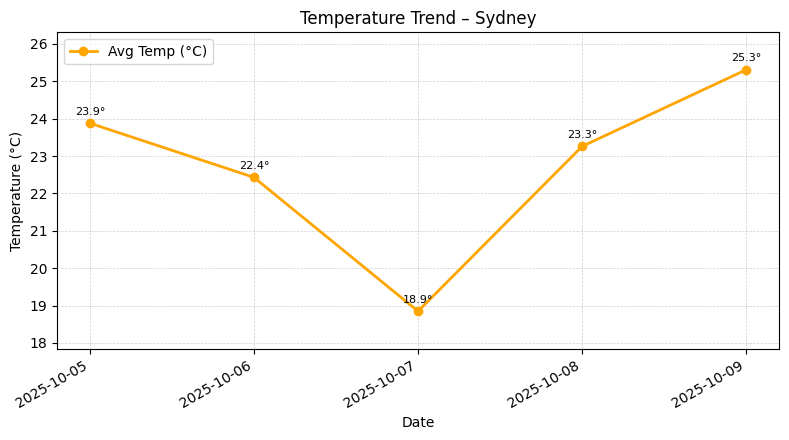


✅ Chart displayed successfully.
You can view another chart or go back to the main menu.

------------------------------------------------------------


What would you like to visualise?
Please select one of the following:
1. Temperature Trend
2. Precipitation Probability
3. Temperature Range (Min–Max)
4. Wind & Humidity (Current)
5. Back to Main Menu
2
ℹ️  You chose: Precipitation Probability


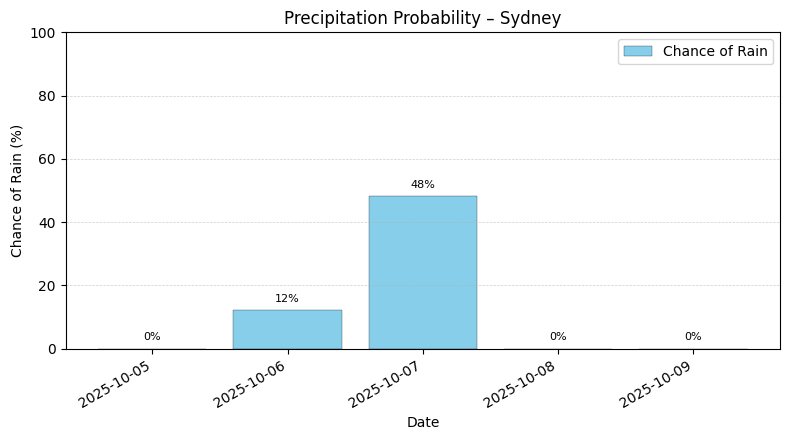


✅ Chart displayed successfully.
You can view another chart or go back to the main menu.

------------------------------------------------------------


What would you like to visualise?
Please select one of the following:
1. Temperature Trend
2. Precipitation Probability
3. Temperature Range (Min–Max)
4. Wind & Humidity (Current)
5. Back to Main Menu
3
ℹ️  You chose: Temperature Range (Min–Max)


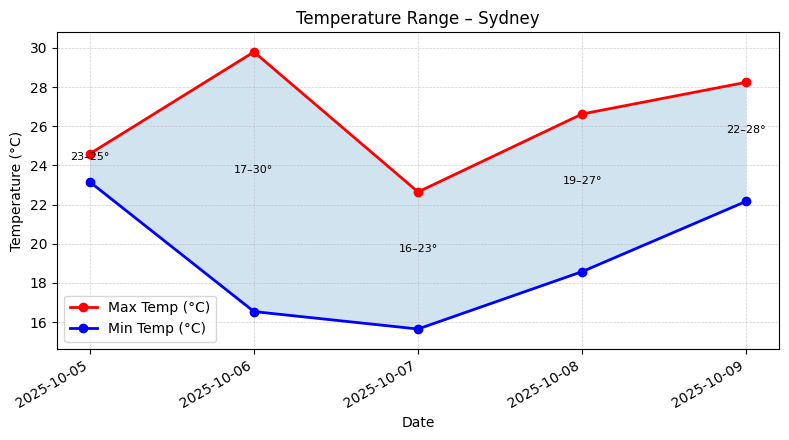


✅ Chart displayed successfully.
You can view another chart or go back to the main menu.

------------------------------------------------------------


What would you like to visualise?
Please select one of the following:
1. Temperature Trend
2. Precipitation Probability
3. Temperature Range (Min–Max)
4. Wind & Humidity (Current)
5. Back to Main Menu
4
ℹ️  You chose: Wind & Humidity (Current)


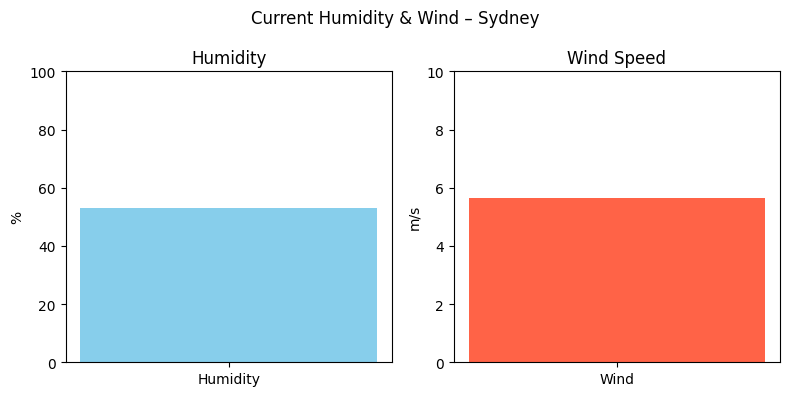


✅ Chart displayed successfully.
You can view another chart or go back to the main menu.

------------------------------------------------------------


What would you like to visualise?
Please select one of the following:
1. Temperature Trend
2. Precipitation Probability
3. Temperature Range (Min–Max)
4. Wind & Humidity (Current)
5. Back to Main Menu
5
ℹ️  You chose: Back to Main Menu
ℹ️  Returning to Main Menu...

Weather Wise — Main Menu
Please select one of the following:
1. Dashboard
2. Chat
3. Quick Fetch (Debug)
4. Settings
5. Exit
2

Chat Mode
🌸 Hi there! I’m Aurora — your Weather Wise chatbot assistant ☁️
You can ask me about:
• 🌤  Weather forecasts (temperature, rain, wind, humidity)
• 🥾 Activity recommendations (currently available for hiking only)
💡 Tip: Please include a city or location in your question so I can fetch accurate results.
Examples:
• Will it rain tomorrow in Sydney?
• Is tomorrow good for hiking in Perth?
• Show temperature for the next 3 days in Melbourne
If

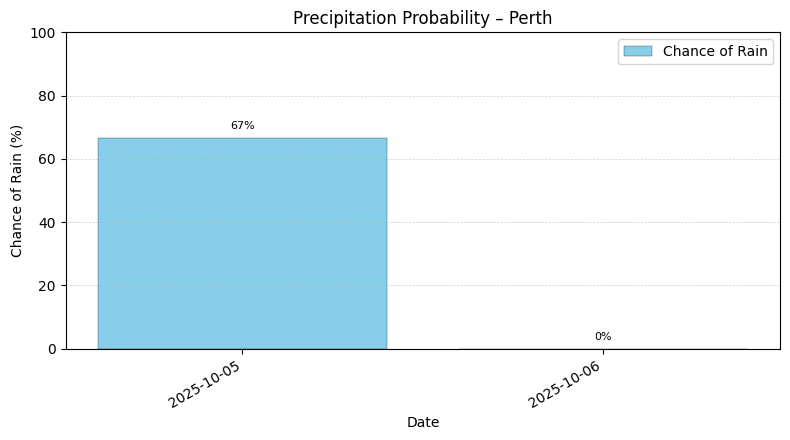


✅ Chart (if any) displayed. Ask another question, or type 'back' to return.
------------------------------------------------------------
🧑 You: Will it rain tomorrow in P?
ℹ️  No city detected. Using default: Perth,AU
💬 Aurora: Probably not. Chance of rain tomorrow (2025-10-06) in Perth is 0%.



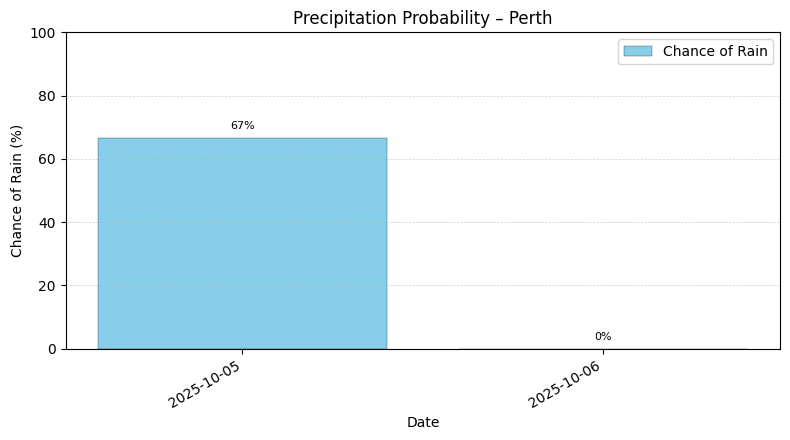


✅ Chart (if any) displayed. Ask another question, or type 'back' to return.
------------------------------------------------------------
🧑 You: Weather in RandomCityZZ?
🙁 Aurora: City not found: 'RandomCityZZ'.
Try another city? (yes/no): yes
Enter a city (e.g., 'Melbourne,AU'): Bali
💬 Aurora: Currently in Bali: Overcast clouds, 28.6°C.


✅ Chart (if any) displayed. Ask another question, or type 'back' to return.
------------------------------------------------------------
🧑 You: Is this week good for hiking in Bali?
💬 Aurora: Recommendation for hiking in Bali (next 3 days):
- 2025-10-05: ⚠️ Fair (60/100) — high rain chance
- 2025-10-06: ✅ Good (80/100) — possible showers
- 2025-10-07: ✅ Good (100/100) — conditions look fine

Best day: 2025-10-07 (score 100/100).


✅ Chart (if any) displayed. Ask another question, or type 'back' to return.
------------------------------------------------------------
🧑 You: back
👋 Aurora: Goodbye! Stay safe and enjoy your day ☀️

Weather Wise — Main Me

In [83]:
# LAUNCH THE INTERACTIVE APP

run_app()

## 🧪 Testing and Examples

This section validates that the Weather Wise application meets all testing requirements in the assignment rubric.
It checks:
- Function signature conformance (get_weather_data(location, forecast_days=5)),
- Proper use of environment variables (OPENWEATHER_API_KEY or OWM_API_KEY),
- Graceful handling of API failures, timeouts, and incomplete data,
- Use of the requests library with safe exception handling, and
- Example calls for key helper functions to illustrate expected behaviour.

### API Compatibility and Network Error Tests

In [ ]:
# This cell tests the robustness and marking rubric compliance of get_weather_data().
# It verifies that the function handles:
#   • Missing or invalid API key
#   • Invalid city (404)
#   • Rate limiting (429)
#   • Gateway/server errors (502)
#   • Timeout exceptions
#   • Incomplete data (missing fields)
# And confirms: proper signature, safe error handling, and use of requests.get.

import os, inspect, requests, json as _json
from contextlib import contextmanager

# --- 1️⃣ Ensure environment key compatibility -----------------
if os.environ.get("OPENWEATHER_API_KEY") and not os.environ.get("OWM_API_KEY"):
    os.environ["OWM_API_KEY"] = os.environ["OPENWEATHER_API_KEY"]

print("API key sources ->",
      "OPENWEATHER_API_KEY:", bool(os.environ.get("OPENWEATHER_API_KEY")),
      "| OWM_API_KEY:", bool(os.environ.get("OWM_API_KEY")))

# --- 2️⃣ Verify function signature -----------------------------
sig = inspect.signature(get_weather_data)
print("\nFunction signature:", sig)
if "location" in sig.parameters and "forecast_days" in sig.parameters:
    print("✅ Signature conforms to required format.")
else:
    print("❌ Signature mismatch — must accept (location, forecast_days=5).")

# --- 3️⃣ Mock network responses --------------------------------
class _FakeResponse:
    def __init__(self, status_code=200, json_body=None, raise_timeout=False):
        self.status_code = status_code
        self._json = json_body or {}
        self._raise_timeout = raise_timeout
        self.text = _json.dumps(self._json)
    def json(self):
        if self._raise_timeout:
            raise requests.exceptions.Timeout("Simulated timeout in json()")
        return self._json
    def raise_for_status(self):
        if 400 <= self.status_code:
            raise requests.exceptions.HTTPError(f"HTTP {self.status_code}")

@contextmanager
def mock_requests_get(responder):
    """Temporarily patch requests.get with a mock responder."""
    original = requests.get
    def _wrapper(url, params=None, **kwargs):
        return responder(url, params or {})
    requests.get = _wrapper
    try:
        yield
    finally:
        requests.get = original

# --- 4️⃣ Prepare sample JSON payloads ---------------------------
CURRENT_OK = {
    "cod": 200, "name": "Perth", "sys": {"country": "AU"},
    "coord": {"lat": -31.95, "lon": 115.86}, "timezone": 28800,
    "weather": [{"description": "clear sky", "icon": "01d"}],
    "main": {"temp": 24.3, "humidity": 44}, "wind": {"speed": 3.1}
}
FCST_OK = {
    "list": [
        {"dt_txt": "2025-10-05 00:00:00", "main": {"temp": 22.0},
         "weather": [{"description": "clear sky"}], "pop": 0.1},
        {"dt_txt": "2025-10-06 00:00:00", "main": {"temp": 25.0},
         "weather": [{"description": "few clouds"}], "pop": 0.3}
    ]
}

# --- 5️⃣ Define responders for different scenarios --------------
def ok(url, p): return _FakeResponse(200, CURRENT_OK if "weather" in url else FCST_OK)
def not_found(url, p): return _FakeResponse(404, {"cod": 404, "message": "city not found"})
def bad_key(url, p): return _FakeResponse(401, {"cod": 401, "message": "invalid api key"})
def rate_limit(url, p): return _FakeResponse(429, {"cod": 429, "message": "too many requests"})
def gateway_err(url, p): return _FakeResponse(502, {"cod": 502, "message": "bad gateway"})
def timeout_err(url, p): raise requests.exceptions.Timeout("Simulated timeout")
def incomplete(url, p):
    if "weather" in url:
        return _FakeResponse(200, {"cod": 200, "name": "Perth", "main": {"temp": 22.5}})
    else:
        return _FakeResponse(200, FCST_OK)

scenarios = [
    ("✅ Success (200/200)", ok),
    ("❌ City not found (404)", not_found),
    ("❌ Invalid API key (401)", bad_key),
    ("⚠️  Rate limited (429)", rate_limit),
    ("⚙️  Gateway/server error (502)", gateway_err),
    ("⏱️  Timeout exception", timeout_err),
    ("⚠️  Incomplete data", incomplete),
]

# --- 6️⃣ Run all scenarios --------------------------------------
for label, responder in scenarios:
    print(f"\n—— {label} ——")
    try:
        with mock_requests_get(responder):
            result = get_weather_data("Perth,AU", forecast_days=2, include_hourly_24h=True, use_cache=False)
        if isinstance(result, dict) and "error" in result:
            print("Returned error dict:", result["error"])
        else:
            loc = result.get("location", {}).get("name")
            print(f"Returned OK, location={loc}, daily={len(result.get('daily', []))}")
    except Exception as e:
        print("❌ Exception not caught:", repr(e))

### Sample Inputs and Outputs for Core Functions

In [ ]:
# 🧭 Functionality Examples — Demonstrating Key Components

# --- 1️⃣ Location validation & normalisation -------------------
print("validate_location_format('Perth,AU') →", validate_location_format("Perth,AU"))
print("validate_location_format('123') →", validate_location_format("123"))
print("normalize_city_input('melb') →", normalize_city_input("melb"))

# --- 2️⃣ Date parsing (NLP helper) -----------------------------
print("_try_parse_date_to_iso('2025-10-08') →", _try_parse_date_to_iso("2025-10-08"))
print("_try_parse_date_to_iso('8 October 2025') →", _try_parse_date_to_iso("8 October 2025"))

# --- 3️⃣ NLP question parsing ----------------------------------
q1 = "Will it rain tomorrow in Perth?"
q2 = "Show temperature for the next 3 days in Sydney"
q3 = "Is it good for hiking this weekend in Melbourne?"

print("\nparse_weather_question(q1) →", parse_weather_question(q1))
print("parse_weather_question(q2) →", parse_weather_question(q2))
print("parse_weather_question_with_activities(q3) →", parse_weather_question_with_activities(q3))

# --- 4️⃣ Activity recommendation demo ---------------------------
sample_weather = {
    "location": {"name": "Perth"},
    "daily": [
        {"date": "2025-10-05", "temp_avg": 23, "temp_min": 17, "temp_max": 26, "pop": 10},
        {"date": "2025-10-06", "temp_avg": 32, "temp_min": 24, "temp_max": 36, "pop": 40},
        {"date": "2025-10-07", "temp_avg": 18, "temp_min": 12, "temp_max": 20, "pop": 80},
    ]
}
print("\nrecommend_activity(sample_weather, 'hiking') →\n", recommend_activity(sample_weather, 'hiking'))

# --- 5️⃣ Natural language generation ----------------------------
pq = parse_weather_question("Will it rain today in Perth?")
wd = {
    "location": {"name": "Perth", "timezone_offset_seconds": 28800},
    "current": {"temp": 22.5, "description": "clear sky", "wind_speed": 3.4, "humidity": 50},
    "daily": [{"date": "2025-10-05", "temp_avg": 23, "temp_min": 17, "temp_max": 27, "pop": 15, "description": "clear"}]
}
print("\ngenerate_weather_response(pq, wd) →", generate_weather_response(pq, wd))

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.